- 5:40 = 550 Sec
- 2:40 = 

# `TOC:`
* [Question-1](#Question-1)
  * [Part-(a)](#Part-(a))
  * [Part-(b)](#Part-(b))
  * [Part-(c)](#Part-(c))
  * [Part-(d)](#Part-(d))
* [Question-2](#Question-2)
  * [Part-(a)](#Part-(a))
  * [Part-(b)](#Part-(b))

Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

# Question-1

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [4]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [5]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

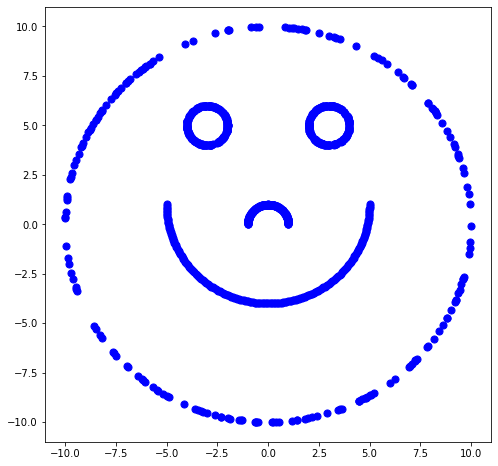

In [6]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

## Part-(a)

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

In [7]:

# func to plot 2D data with cluster IDs
# Input:
# data_2d: Data points in 2D :: If higher dim then can give PCA(2) applied data
# labels: cluster IDs array
# n_cluster: no of clusters; default = 4
# Output:
# plots a 2D scatter map with legend

def plot_clusters(data_2d,labels,n_cluster=4):
    # filter rows of original data
    # for label in labels
    fig = plt.figure( figsize = (8, 8) )
    plt.figure(fig.number)
    for cluster in range(n_cluster):
        label0 = data_2d[labels == cluster]
        plt.scatter(label0[:,0] , label0[:,1],label=cluster)
    
    plt.legend(fontsize='small')
    plt.show()

In [8]:
# to get max float point from system
import sys

In [67]:

# k menas clustering algo implementation
# Input:
# X: data points
# n_cluster: no of clusters; default = 4
# init_style: initial cluster choosing style; default = k-menas
#     - k-means: to choose initial clusters randomly
#     - k-menas++: to choose initial clusters usefully
# Output:
# Cluster labels for data points
# and some meta info
 
def get_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=1000):

    # to reproduce results 
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]

    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]

    #====================================================   
    # k-means++ implementation     
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0,:]=X[init_centroids_index[-1],:]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                tmp[:,j]=np.sum(np.sqrt((X-init_centroids[j,:])**2),axis=1)

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)

            # to be safe for repeating centroids
            tmp_prob[tmp_prob < 1e-8] = 0

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    #====================================================

    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''
    curr_centroids=init_centroids
   
    # to store cluster assignment and error info after each iteration
    # error info is used to get idea about `elbow`
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=1e-4
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    '''
    Two convergence criterians are used for stopping:
    1. one is simple n_iter condition
    2. second one is when objective func is pretty much same in iterations  
    '''
    while (iter_error_diff>error_tol) and (iter_count<n_iter):
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            tmp_array[:,cluster]=np.sum((X-curr_centroids[cluster,:])**2,axis=1)
        
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            curr_objective_value+=np.sum(np.sum((tmp_cluster_points-tmp_centroid)**2,axis=0),axis=0) # scalar
            curr_centroids[cluster,:]=tmp_centroid # update cluster centroid
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        iter_error_diff=new_objective_value-curr_objective_value
        new_objective_value=curr_objective_value
        
    # return cluster ids for each of the data points in X with some history info
    return {'final':tmp_cluster_assign,'history':cluster_history,'iter-count':iter_count,'wacc-history':wacc_history,'final-centroids':curr_centroids,'start-centroids':init_centroids}

For random k-means initalization with 5 clusters


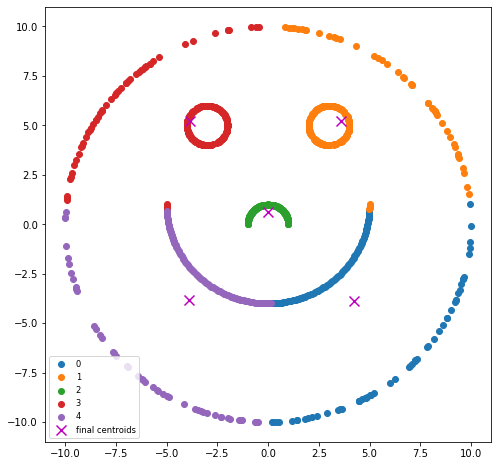

In [72]:
print(''.center(50,'='))
print('For random k-means initalization with 5 clusters')
print(''.center(50,'='))

no_of_clusters=5
model=get_KMeans_clusters(X,n_cluster=no_of_clusters)
centroids=model['final-centroids']
fig = plt.figure( figsize = (8, 8) )
plt.figure(fig.number)
for cluster in range(no_of_clusters):
    label0 = X[model['final'] == cluster]
    plt.scatter(label0[:,0] , label0[:,1],label=cluster)
plt.scatter(centroids[:,0],centroids[:,1],s=100,c='m',marker='x',label='final centroids')
plt.legend(fontsize='small')
plt.show()

## Part-(b)

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]

#### NOTE:
Implementation of `k-means++` has been done with part-(a) to avoid repeat. Please see part-(a) '====' section in code.

**k-means++ visualization:**\
Below plot is with k-means++ initalization

k-means++ initalization with 5 clusters


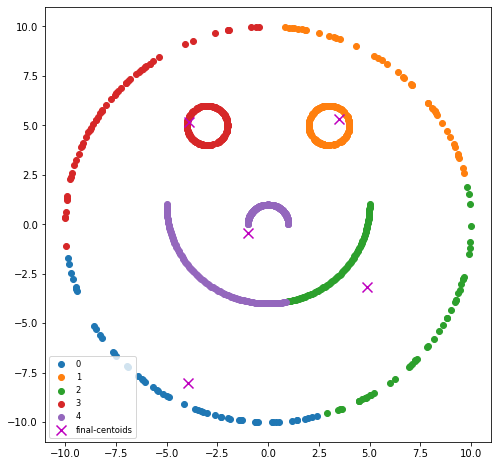

In [74]:
print(''.center(50,'='))
print('k-means++ initalization with 5 clusters')
print(''.center(50,'='))

no_of_clusters=5
model=get_KMeans_clusters(X,n_cluster=no_of_clusters,init_style='k-means++')
centroids=model['final-centroids']
fig = plt.figure( figsize = (8, 8) )
plt.figure(fig.number)
for cluster in range(no_of_clusters):
    label0 = X[model['final'] == cluster]
    plt.scatter(label0[:,0] , label0[:,1],label=cluster)
plt.scatter(centroids[:,0],centroids[:,1],s=100,c='m',marker='x',label='final-centroids')
plt.legend(fontsize='small')
plt.show()

## Part-(c)

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]

### elbow analysis with kmeans random

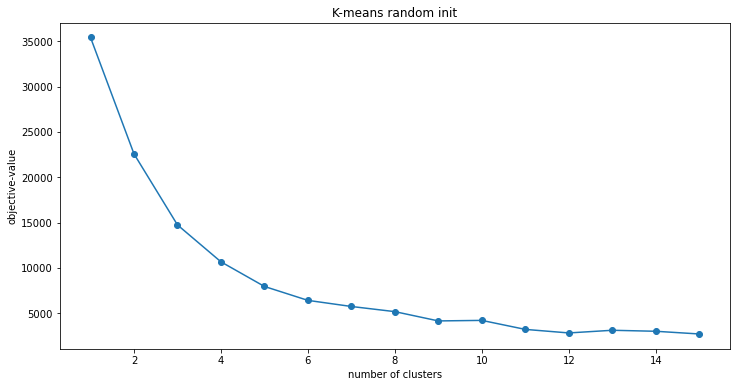

In [76]:
# fitting multiple k-means algorithms with different n_clusters and storing the values in an empty list
objective_value = []
max_cluster=15
for cluster in range(1,max_cluster+1):
    kmeans = get_KMeans_clusters(X,n_cluster=cluster)
    objective_value.append(kmeans['wacc-history'][-1])

# plotting the results
plt.figure(figsize=(12,6))
plt.plot(list(range(1,max_cluster+1)), objective_value, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('objective-value')
plt.title('K-means random init')
plt.show()

**Observations:**
- around 5 clusters there seems an elbow.

### elbow analysis with kmeans++

Text(0.5, 1.0, 'K-means++ init')

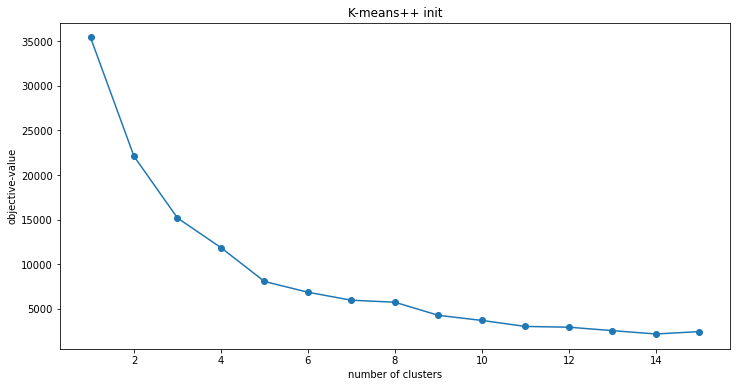

In [77]:
# fitting multiple k-means algorithms with different n_clusters and storing the values in an empty list
objective_value = []
max_cluster=15
for cluster in range(1,max_cluster+1):
    kmeans = get_KMeans_clusters(X,n_cluster=cluster,init_style='k-means++') # with kmeans++
    objective_value.append(kmeans['wacc-history'][-1])

# plotting the results
plt.figure(figsize=(12,6))
plt.plot(list(range(1,max_cluster+1)), objective_value, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('objective-value')
plt.title('K-means++ init')

**Observations:**
- around 5 clusters there seems an elbow.
- Both methods are giving no of clusters for this data set to be `5`.

### AM I HAPPY WITH THIS CLUSTERING?
- NO, I DON'T THINK SO.
- These are only linear cluster coundaries. I was hoping it would cluster `eye1`, `eye1`, `nose`, `mouth` and `face` in different clusters but that would need non-linear boundaries. At least to cluster whole face into one cluster we will need non-linear boundary. Other items that could have been clustered with linear boundaries, that also is not being done by it.
- Basically non-linear boundaries are not sufficient to cluster this smily face into nice clusters. And for that we can kernalize k-means algorithm.
- It has been implemented in Part-(d).

## Part-(d)

(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

In [55]:
LAMBDA=0.1
def kernel_dist(X,centroid):
    # exact formula is given in kernel kmeans slide 
    return 2*(1-(np.exp(-LAMBDA * np.sum((X-centroid)**2,axis=1))))

'''
k menas clustering algo implementation
Input:
X: data points
n_cluster: no of clusters; default = 4
init_style: initial cluster choosing style; default = k-menas
    - k-means: to choose initial clusters randomly
    - k-menas++: to choose initial clusters usefully
Output:
Cluster labels for data points
''' 
def get_kernel_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=10):

    # to reproduce results
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]
    
    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]
        # another way is to create k-many random centroids that are not data points
        #TODO: implement this one also with if-else cond
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0]=X[init_centroids_index[-1]]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                #TODO:done
                tmp[:,j]=np.sqrt(kernel_dist(X,init_centroids[j,:]))

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)
            # print(np.min(tmp_prob))

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''

    curr_centroids=init_centroids

    # to store cluster assignment and error info after each iteration
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=10**(-4)
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    while (iter_error_diff>error_tol) and (iter_count<n_iter):
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            #TODO:done
            tmp_array[:,cluster]=kernel_dist(X,curr_centroids[cluster,:])
        # print(tmp_cluster_assign)
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        # print(tmp_cluster_assign)
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            #TODO:??
            tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            #TODO:done:done

            curr_objective_value+=np.sum(kernel_dist(tmp_cluster_points,tmp_cluster_points)) # scalar
            curr_centroids[cluster,]=tmp_centroid # update cluster centroid
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        iter_error_diff=new_objective_value-curr_objective_value
        new_objective_value=curr_objective_value
    return tmp_cluster_assign

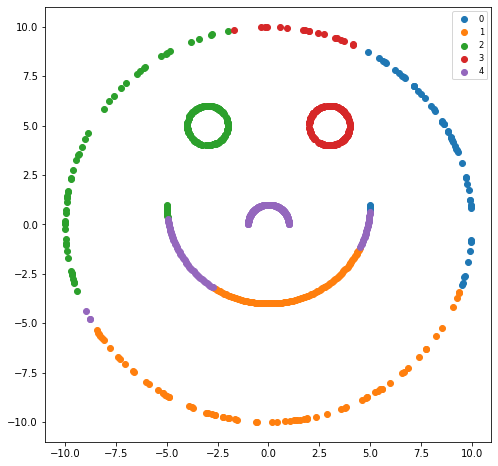

In [56]:
plot_clusters(X,get_kernel_KMeans_clusters(X,n_iter=1000,n_cluster=5,init_style="k-means++"),n_cluster=5)

- the below one is painfully slow; Time complexity for each update iteration: $\mathcal{O}(KN^3)$

In [57]:
# this module is used to get idea about time it takes
from time import time
# set this variable to change lambda in guassian kernel
LAMBDA=0.1
def pair_kernel_dist(x,y):
    return np.exp(-LAMBDA * np.sum((x-y)**2))
    
def pair_kernel_dist_total(x,cluster_points):
    # math is bit involving given in markdowns
    # tic=time()
    n_points_=len(cluster_points)
    return_dist=0
    for i,point1 in enumerate(cluster_points):
        return_dist-=(2/n_points_)*pair_kernel_dist(x,point1)
        
    # toc=time()
    # print(toc-tic)
    return return_dist
def kernel_dist(X,centroid):
    tic=time()
    n_points_=len(centroid)
    centroid_points_dist=n_points_
    for i in range(n_points_):
        for j in range(n_points_):
            # this one is 2 times faster than the below one
            if j>i:
                centroid_points_dist+=2*pair_kernel_dist(centroid[i,],centroid[j,])
            # below one is inefficient
            # if i!=j:
            #     centroid_points_dist+=pair_kernel_dist(centroid[i,],centroid[j,])
    centroid_points_dist=centroid_points_dist/(n_points_**2)
    toc=time()
    print(toc-tic)
    
    return_array=np.empty(X.shape[0])
    for i,x in enumerate(X):
        return_array[i]=pair_kernel_dist_total(x,centroid)+centroid_points_dist
    
    return return_array
def k(X,centroid):
    # exact formula is given in kernel kmeans slide 
    return 2*(1-(np.exp(-LAMBDA * np.sum((X-centroid)**2,axis=1))))

'''
k menas clustering algo implementation
Input:
X: data points
n_cluster: no of clusters; default = 4
init_style: initial cluster choosing style; default = k-menas
    - k-means: to choose initial clusters randomly
    - k-menas++: to choose initial clusters usefully
Output:
Cluster labels for data points
''' 
def get_kernel_KMeans_clusters(X,n_cluster=4,init_style='k-means',n_iter=2):

    # to reproduce results
    # np.random.seed(1)

    n_points=X.shape[0]
    n_dim=X.shape[1]

    '''
    Get Inital Centroids
    '''
    # cluster centers are chosen to be K of the data points themselves #
    if init_style=='k-means':

        # this method simply chooses random n_cluster points from permuatated index
        init_centroids_index=rnd.permutation(n_points)[:n_cluster]
        init_centroids=X[init_centroids_index]
        # another way is to create k-many random centroids that are not data points
        #TODO: implement this one also with if-else cond
    elif init_style=='k-means++':
        # in this we choose centroids that are more representative of the sample points
        # empty array and list
        init_centroids=np.empty((n_cluster, n_dim))
        init_centroids_index=list()

        init_centroids_index.append(rnd.randint(n_points))
        init_centroids[0]=X[init_centroids_index[-1]]
       
        for i in range(1,n_cluster):
            
            # new_X=np.delete(X,init_centroids_index,axis=0)
            # no need to create a new array(2D) from X based on only unselected points
            # bcz probability for them would be zero; so they would not be selected again
             
            tmp=np.empty((n_points,i))
            for j in range(i):
                #TODO:done
                # tmp[:,j]=np.sqrt(kernel_dist(X,init_centroids[j,:]))
                tmp[:,j]=np.sqrt(k(X,init_centroids[j,:]))

            tmp_min=np.min(tmp,axis=1) # min(D(X)) for each unselected point

            # convert them into probabilities
            tmp_prob=tmp_min/np.sum(tmp_min)
            print(np.sum(tmp_min))

            # possible index values
            values=list(range(0,1000))
            # choose an index randomly based on probability
            next_centriod= np.random.choice(a=values, size=1, p=tmp_prob)[0]
            # add next centroid to the list and empty array
            init_centroids_index.append(next_centriod)
            init_centroids[i]=X[init_centroids_index[-1]]
    else:
        print('give a valid choice for init_style')
        return None
    
    '''
    KMeans Iterations
    '''
    curr_centroids=list()
    for i in range(n_cluster):
        curr_centroids.append(init_centroids[i,])

    # to store cluster assignment and error info after each iteration
    cluster_history=list()
    wacc_history=list()

    # for stopping/convergance criterian
    error_tol=10**(-4)
    iter_error_diff=1 
    iter_count=0
    new_objective_value=sys.float_info.max

    while iter_count<n_iter:
        # increase iter_count
        iter_count+=1
        
        # create empty temp array to store euclidean dist-sum from cluster centroids
        # do it for each cluster centroid
        tmp_array=np.empty((n_points, n_cluster))

        for cluster in range(n_cluster):
            # here distance is euclidean
            #TODO:done
            tmp_array[:,cluster]=kernel_dist(X,curr_centroids[cluster])
        # print(tmp_cluster_assign)
        # assign cluster to each point based on min distance from the cluster
        tmp_cluster_assign=np.argmin(tmp_array,axis=1)
        cluster_history.append(tmp_cluster_assign)
        # print(tmp_cluster_assign)
        # update centeroids by cluster point mean
        curr_objective_value=0
        for cluster in range(n_cluster):
            tmp_cluster_points=X[(tmp_cluster_assign==cluster),:] # 2D array
            #TODO:??
            # tmp_centroid=np.mean(tmp_cluster_points,axis=0) # 1D mean array
            #TODO:done:done
            # print(tmp_cluster_points)
            # curr_objective_value+=np.sum(kernel_dist(tmp_cluster_points,tmp_cluster_points)) # scalar
            curr_centroids[cluster]=tmp_cluster_points # update cluster centroid
        # print(curr_centroids)
        wacc_history.append(curr_objective_value) # add curr error value to history

        # update difference
        # iter_error_diff=new_objective_value-curr_objective_value
        # new_objective_value=curr_objective_value
    return tmp_cluster_assign
    # return cluster ids for each of the data points in X with some history info
    # return {'final':tmp_cluster_assign,'history':cluster_history,'iter-count':iter_count,}#'wacc-history':wacc_history,'final-centroids':curr_centroids,'start-centroid':init_centroids_index}a

1224.207253723408
990.5430551658487
824.5325434145777
761.2472799647028
4.6253204345703125e-05
4.2438507080078125e-05
3.0279159545898438e-05
8.630752563476562e-05
3.218650817871094e-05
0.11591958999633789
0.20031285285949707
0.35367417335510254
0.06572341918945312
0.15518712997436523
0.14472031593322754
0.1463761329650879
0.11939120292663574
0.2067115306854248
0.13305139541625977
0.16160154342651367
0.1490161418914795
0.15398716926574707
0.14287066459655762
0.1479635238647461
0.17860174179077148
0.15900421142578125
0.2048642635345459
0.15096735954284668
0.15251827239990234


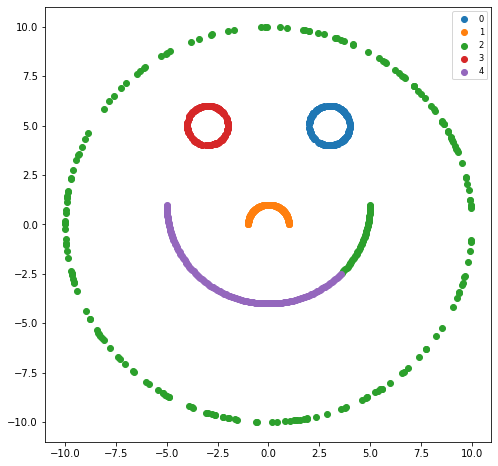

In [58]:
plot_clusters(X,get_kernel_KMeans_clusters(X,n_cluster=5,n_iter=5,init_style='k-means++'),n_cluster=5)

- it is too slow; have to use other techniques that might work faster; basically transfer data into hilbert space and use k-means clustering

# Question-2

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

## Part-(a)

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ `are known`, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

### EM for Modified GMM
The modification is that we know class probabilities of Gaussian mixture model. In stansard GMM, we estimate class probabilities($\pi_k$) also by EM algorithm iterations.\

**Model Info:**\
Supppose $X_1,X_2,\ldots,X_n \sim F$, where $F$ is mixture of $K$ Gaussian distribution. And we know the weights of individual Gaussian in the mixture, it is known to be $\pi_k$.\
We have seen that there is no analytical solution for the estimation of mean and covariance of Gaussians. We could solve it using gradient-based tools, that would only lead to more complication. Rather we introduce a latent variable and try to use latent variable model to solve for mean and covariance of Gaussians.\

**Parameters:**\
Since we already know class prob. we only need to get estimate for mean and covariance of each Gaussian in the mixture. So model parametrs are:
$$
\Theta=\{\mu_k,\sigma_k^2\}_{k=1}^K
$$

**Complete log likelihood(CLL):**\
`Suppose` we have the information that $X_i$ is coming from which of the $K$ Gaussian populations. Thus, suppose the complete data was of the form:
$$
(X_1,Z_1),(X_2,Z_2),\ldots,(X_n,Z_n)
$$
where each $Z_i = k$ means that $X_i$ is from population $k$. If this complete data is
available to us, then the joint density for one observation is[using Bayes rule]:
$$
p(x_i,z_i|\Theta)=p(x_i|z_i,\Theta)p(z_i|\Theta)
$$
For the full data complete likelihood can be given, assuming that observations are `i.i.d.`:
$$
\mathcal{L}(\Theta|X)=p(X,Z|\Theta) \\
=\prod_{n=1}^N p(x_i,z_i|\Theta) \\
=\prod_{n=1}^N p(x_i|z_i,\Theta)p(z_i|\Theta) \\
=\prod_{n=1}^N \left(\prod_{k=1}^K \pi_k^{z_{nk}} \prod_{k=1}^K p(x_i|z_i=k,\Theta)^{z_{nk}}\right)\\
=\prod_{n=1}^N \prod_{k=1}^K [\pi_k p(x_i|z_i=k,\Theta)]^{z_{nk}} \\
=\prod_{n=1}^N \prod_{k=1}^K [\pi_k \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)]^{z_{nk}}
$$
Log of the complete likelihood can be given as:
$$
CLL=log(\mathcal{L}(\Theta|X)=p(X,Z|\Theta)) \\
= log \prod_{n=1}^N \prod_{k=1}^K [\pi_k \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)]^{z_{nk}} \\
= \sum_{n=1}^N \sum_{k=1}^K z_{nk}[log\pi_k + log \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)]
$$
Now we have complete log likelihood in our hand. We can proceed to get EM steps for EM algo.\

**EM steps:**\
We will look at the general setup of $K$ groups, so that the density for $X_1,\ldots,X_n$ is
$$
p(x|\Theta)=\sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k,\sigma_k^2 I)
$$
The setup is same. As we supposed complete data is $\{(X_n,Z_n)\}_{n=1}^N$. First, ee would need to get Expectation of CLL(E-step) for its maximization in M-step. In CLL we need condition distribution of $p(Z|X,\Theta)$. Since observations are `i.i.d.` we can easily get seperatly for each n and k,
$$
p(z_n=k|x_n,\Theta)=\frac{p(x_n|z_n=k,\Theta)p(z_n=k|\Theta)}{p(x_n|\Theta)} \\
=\frac{\pi_k \mathcal{N}(x_n|\mu_k,\sigma_k^2 I)}{p(x_n|\Theta)} \\
=\frac{\pi_k \mathcal{N}(x_n|\mu_k,\sigma_k^2 I)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j,\sigma_j^2 I)}
$$
One can easily check that $\sum_{k=1}^K p(z_n=k|x_n,\Theta) = 1$. For notation ease, we denote it by $\gamma_{nk}$. $\gamma_{nk}$ are itself quantities of interest since they tell us the probability of the $i_{th}$ observation being in class $k$. This helps in classifying the observed data.\

**Expectation of CLL:**\
Note that here $\hat{\Theta}$ is the estimate of $\Theta$ in previous EM iteration. I also have used standard properties of expectation here.
$$
\mathbf{E}(CLL)=\mathbf{E}_{p(Z|X,\Theta)}[log(X,Z|\Theta)] \\
=\mathbf{E}_{p(Z|X,\Theta)}\left[ \sum_{n=1}^N \sum_{k=1}^K z_{nk}[log\pi_k + log \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)] \right] \\
=\sum_{n=1}^N \sum_{k=1}^K \mathbf{E} \left[ z_{nk}[log\pi_k + log \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)] \right] \\
=\sum_{n=1}^N \sum_{k=1}^K \left[ \mathbf{E}[z_{nk}][log\pi_k + log \mathcal{N}(x_i|\mu_k,\sigma_k^2 I)] \right] \\
$$

**Maximization of Expectation:**\
In M step to get updates for $\Theta=\{\mu_k,\sigma_k^2\}_{k=1}^K$, we maximize the expecation like we do in MLE computation.
$$
\hat{\Theta}=argmax_{\Theta} \mathbf{E}(CLL) \\
$$
After substituting Gaussian distribution in CLL, we solve above optimization problem for each parameter,
$$
\mathbf{E}(CLL)=\sum_{n=1}^N \sum_{k=1}^K \left[ \mathbf{E}[z_{nk}][log\pi_k - \frac{1}{2}log(2\pi) -\frac{1}{2}log(\sigma_k^2) -\frac{(x_n-\mu_k)^{T}(x_n-\mu_k)}{2 \sigma_k^2}] \right] \\
=const - \frac{1}{2} \sum_{n=1}^N \sum_{k=1}^K \mathbf{E}[z_{nk}] log(\sigma_k^2) - \sum_{n=1}^N \sum_{k=1}^K \mathbf{E}[z_{nk}] \frac{(x_n-\mu_k)^{T}(x_n-\mu_k)}{2 \sigma_k^2}
$$
Note that we have ignored constant terms here. Specially in general GMM we had term $ \mathbf{E}[z_{nk}]log\pi_k$ there but we no loger have it because $\pi_k$ is known to us and thus it also becomes a constant. Taking derivatives and setting to 0, we get For any class $k$,
$$
\frac{\partial(ECLL)}{\partial(\mu_k)}=\sum_{n=1}^N \frac{(x_n-\mu_k)\mathbf{E}[z_{nk}]}{\sigma_k^2}
$$
Set above to zero and we get:
$$
\hat{\mu_k}=\frac{\sum_{n=1}^N \mathbf{E}[z_{nk}] x_n }{\sum_{n=1}^N \mathbf{E}[z_{nk}]}
$$
When we do second derivative for it we clearly have $\frac{\partial^2(ECLL)}{\partial(\mu_k)^2}<0$. So $\hat{\mu_k}$ also passes second order maxima condition. Now for $\sigma_k^2$ we do the same,
$$
\frac{\partial(ECLL)}{\partial(\sigma_k^2)}=\sum_{n=1}^N \mathbf{E}[z_{nk}] \frac{(x_n-\mu_k)^{T}(x_n-\mu_k)}{2 \sigma_k^4} -\frac{1}{2} \sum_{n=1}^N\frac{\mathbf{E}[z_{nk}]}{\sigma_k^2}
$$
Set above to zero and we get,
$$
\hat{\sigma_k^2}=\frac{\sum_{n=1}^N \mathbf{E}[z_{nk}] (x_n-\hat{\mu_k})^{T}(x_n-\hat{\mu_k})}{\sum_{n=1}^N \mathbf{E}[z_{nk}]}
$$
For $\sigma_k^2$ also the second order maxima condition is satisfied. AS we know $\pi_k$, we don't need to get its estimate. This completes the M-step for EM algorithm. After maximizing we get these results, here we have to compute $\mathbf{E}[z_{nk}]$. Estimate value for it is as follows,
$$
\mathbf{E}[z_{nk}]=0 x p(z_{nk}=0|x_n,\Theta) + 1 x p(z_{nk}=1|x_n,\Theta) \\
=p(z_{nk}=1|x_n,\Theta)\\
=\frac{\pi_k \mathcal{N}(x_n|\mu_k,\sigma_k^2 I)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j,\sigma_j^2 I)}; \forall n,k
=\gamma_{nk}
$$

Now we write EM algo for a general iteration $t$, just keep in mind that to update for $(t)$ we use values from previous iteration $(t-1)$.

**EM Iterations:**
---
1. Initalize $\Theta=\{\mu_k,\sigma_k^2\}_{k=1}^K$ as $\Theta^{(0)}, and set $t=1$
2. Repeat until convergence,
    - **E-step:** compute expectation($\gamma_{nk}$) of each $z_n$ as they are needed in M-step updates. Here $\sigma_k^2 I$ is replaced by $\Sigma_k$ for compact notation.
    $$
    \mathbf{E}[z_{nk}^{(t)}]=\frac{\pi_k \mathcal{N}(x_n|\mu_k^{(t-1)},\Sigma_k^{(t-1)})}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_k^{(t-1)},\Sigma_k^{(t-1)} }; \forall n,k
    $$
    - **M-step:** With $\gamma_{nk}$ in our hand we can re-estimate $\Theta$ via MLE solutions that we got in maximization. Note that in updates $\sum_{n=1}^N \gamma_{nk} = N_k$. $N_k$ is the effective number of points in the k_th cluster. For {\mu,\sigma^2} updates in each k:

    $$
    \mu_k^{(t)}=\frac{1}{N_k}\sum_{n=1}^N \mathbf{E}[z_{nk}^{(t)}]=\frac{1}{N_k}\sum_{n=1}^N \gamma_{nk}^{(t)}
    $$
    $$
    \hat{\sigma_k^2}^{(t)}=\frac{1}{N_k} \sum_{n=1}^N \gamma_{nk}^{(t)} (x_n-\mu_k^{(t)})^{T}(x_n-\mu_k^{(t)})
    $$
3. For next iteration set $t=t+1$ and repeat E-M steps until convergence critarian is met 

## Part-(b)

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

- I have taken 2D Gaussians so that we can visualize the results. Though algo works for any dim Gaussian.

In [ ]:
def get_data(mus,sigmas,n_points=200):
    
    pass

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np

In [85]:
data_dim=2
n_syn_cluster=3
n_points=200
class_probs=[0.3,0.3,0.4]
n_samples=[60,60,80] # automate
values=list(range(0,n_syn_cluster))
true_theta=[np.array([1.4, 1.6]), np.array([2.4, 5.4]), np.array([6.4, 2.4]),1,1,1]
syn_data=[]
for i in range(n_syn_cluster):
    syn_data+=list(np.random.multivariate_normal(true_theta[i], true_theta[i+n_syn_cluster]*np.eye(data_dim), n_samples[i]))
syn_data=np.array(syn_data)
np.random.shuffle(syn_data) 
## above is only one of the way to generate data; others are also there

init_theta=[np.array([1, 1]), np.array([1, 1]), np.array([1, 1]),1,1,1] # means stored in array
curr_theta=init_theta
diff=100
error_tol=1e-10
iter_count=0
max_iter=50
hist_theta=[]
hist_theta.append(curr_theta)

while (iter_count<max_iter):
    
    iter_count+=1

    # E-step
    Ep=np.empty((n_points,n_syn_cluster))
    for i in range(n_syn_cluster):
        Ep[:,i]=class_probs[i]*multivariate_normal.pdf(x=syn_data,mean=curr_theta[i],cov=curr_theta[n_syn_cluster+i]*np.eye(data_dim))
    Ep=Ep/(Ep.sum(axis=1, keepdims=True))
    # print(Ep)
    # M-step
    tmp_theta=list()
    # print(tmp_theta)
    for i in range(n_syn_cluster):
        tmp_theta.append((np.dot(syn_data.T,Ep[:,i].reshape((n_points,1)))/np.sum(Ep[:,i])).reshape((1,data_dim))[0])
    for i in range(n_syn_cluster):
        tmp_theta.append(np.dot(np.sum(np.multiply((syn_data-tmp_theta[i]),(syn_data-tmp_theta[i])),axis=1),Ep[:,i])/np.sum(Ep[:,i]))
    
    '''
    convergence criterian update
    using abs diff :: could use other techniques
    log_lik values used as stopping criterian
    '''
    diff=np.max(np.abs(np.concatenate(tmp_theta,axis=None)-np.concatenate(curr_theta,axis=None)))
    
    # next iter update
    curr_theta=tmp_theta
    hist_theta.append(tmp_theta)
print(curr_theta)

[array([3.66717109, 3.07684042]), array([3.66717109, 3.07684042]), array([3.66717109, 3.07684042]), 9.680115734452404, 9.680115734452404, 9.680115734452404]


In [ ]:
A=multivariate_normal.pdf(x=syn_data,mean=curr_theta[i],cov=curr_theta[n_syn_cluster+i]*np.eye(data_dim))

In [ ]:
Ep=np.empty((200,3))
for i in range(3):
    np.random.shuffle(A)
    Ep[:,i]=A

In [ ]:
B=Ep/Ep.sum(axis=1,keepdims=True)

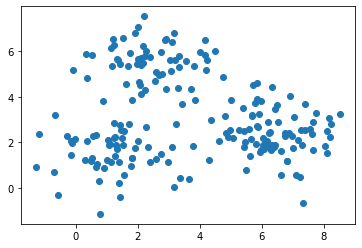

In [87]:
plt.scatter(syn_data[:,0],syn_data[:,1])

In [ ]:
np.array([[3.57596954, 3.00066189]])[0].reshape(1,2)[0]

In [ ]:
syn_data-tmp_theta[i].T

In [73]:
np.dot((np.sum(np.multiply((syn_data-tmp_theta[i]),(syn_data-tmp_theta[i])),axis=1)),Ep[:,1])

573.0591943301075